In [1]:
import json
from pathlib import Path
from PIL import Image as PILImage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from rhana.labeler.unet import RHEEDTensorImage, RHEEDTensorMask, rle_encode, rle_decode
from rhana.labeler.masker import UnetMasker
from rhana.io.kashiwa import find_raw_rheed
from rhana.pattern import Rheed, RheedMask
from rhana.tracker.iou import IOUTracker, regions2detections, IOUMaskTracker

In [2]:
from skimage.draw import disk

In [3]:
masker = UnetMasker("../learner/UNet_May6_2021_fixed.pkl")

In [4]:
ls ../data/STO_vary_temp

270.png  350.png  400.png  480.png  525.png  580.png     600.png  700.png
300.png  375.png  450.png  500.png  550.png  600old.png  660.png


In [5]:
data_folder = Path("../data/STO_vary_temp")

datas = list(data_folder.glob("*.png"))
datas = list(filter(lambda x: x.stem.isdigit(), datas))
datas = sorted(datas, )

In [6]:
datas

[Path('../data/STO_vary_temp/270.png'),
 Path('../data/STO_vary_temp/300.png'),
 Path('../data/STO_vary_temp/350.png'),
 Path('../data/STO_vary_temp/375.png'),
 Path('../data/STO_vary_temp/400.png'),
 Path('../data/STO_vary_temp/450.png'),
 Path('../data/STO_vary_temp/480.png'),
 Path('../data/STO_vary_temp/500.png'),
 Path('../data/STO_vary_temp/525.png'),
 Path('../data/STO_vary_temp/550.png'),
 Path('../data/STO_vary_temp/580.png'),
 Path('../data/STO_vary_temp/600.png'),
 Path('../data/STO_vary_temp/660.png'),
 Path('../data/STO_vary_temp/700.png')]

# Create Mask

In [7]:
rd = Rheed.from_image(datas[-1], )

In [8]:
rd.pattern.max()

0.5647058823529412

In [9]:
rd.pattern = (rd.pattern.clip(0, 1)) * 255/1

<IPython.core.display.Javascript object>


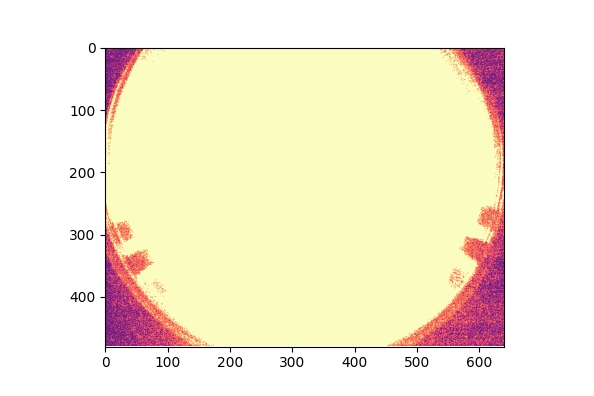

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [57]:
%matplotlib notebook
rd.plot_pattern(cmap="magma")

In [59]:
from skimage.draw import disk

In [60]:
center = rd.pattern.shape[:2]

In [149]:
center = np.array((170, 320))

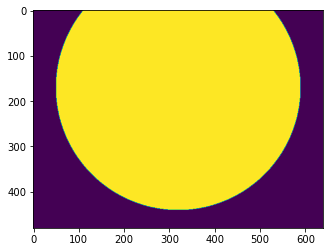

In [150]:
%matplotlib inline
mask = np.zeros(rd.pattern.shape, dtype=bool)
rr, cc = disk(center, radius=270, shape=rd.pattern.shape)
mask[rr, cc] = 1
plt.imshow(mask)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

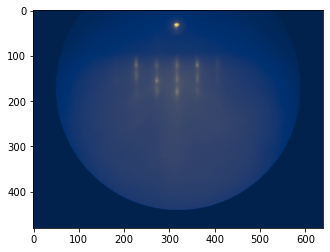

In [151]:
rd = Rheed.from_image(datas[-1], AOI=mask)
rd.plot_pattern()

In [73]:
!mkdir ../tmp

In [152]:
plt.imsave("../tmp/UMD_RHEED_mask.png" , (mask[:, :, None].repeat(3, axis=-1) * 255).astype(np.uint8) )

# Read all rheed

In [10]:
AOI = plt.imread("../tmp/UMD_RHEED_mask.png")[:,:,0]
AOI = AOI.astype(bool)

In [11]:
AOI.shape

(480, 640)

In [12]:
from collections import OrderedDict

In [55]:
rds = OrderedDict()
for data_path in datas:
    rd = Rheed.from_image(data_path, AOI= AOI, rotate=0)
    rd.mean_clip().min_max_scale()
    rds[int(data_path.stem)] = rd

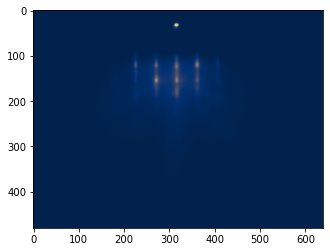

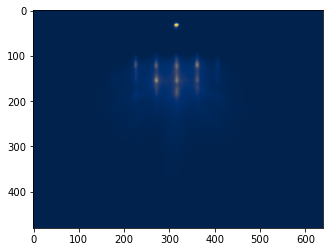

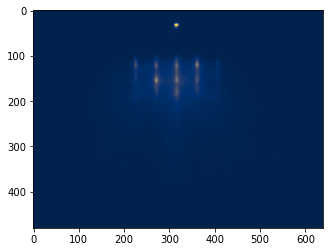

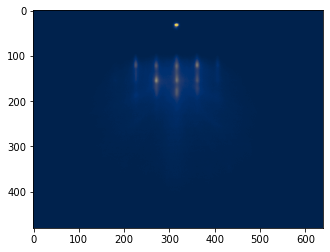

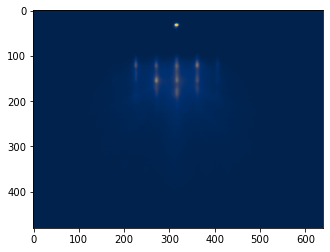

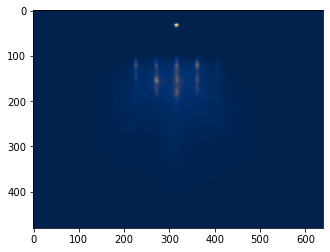

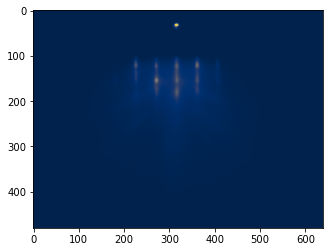

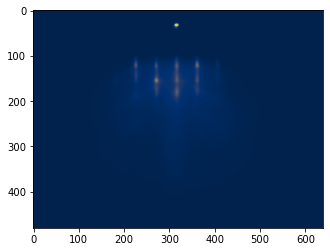

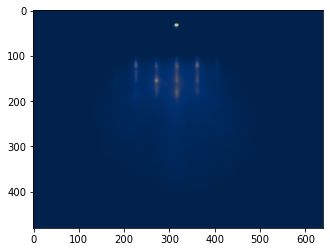

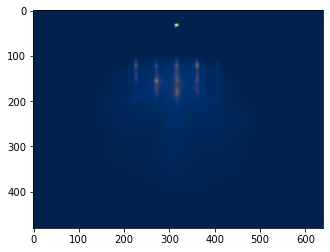

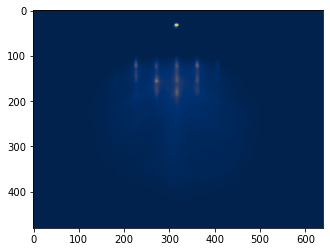

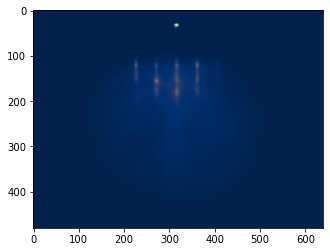

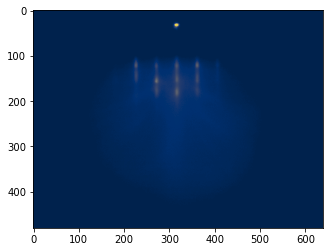

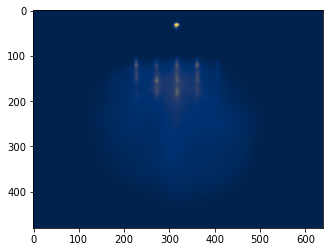

In [56]:
for name, rd in rds.items():
    rd.plot_pattern()

In [57]:
rd.pattern.shape

(480, 640)

In [58]:
rd = rds[270]

In [59]:
offset = 50
window_width = 200
window_height = 200

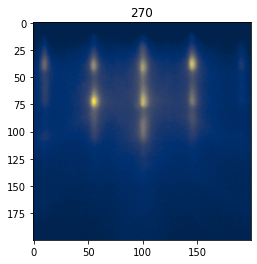

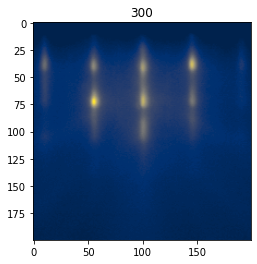

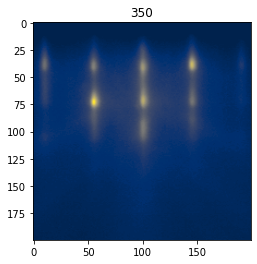

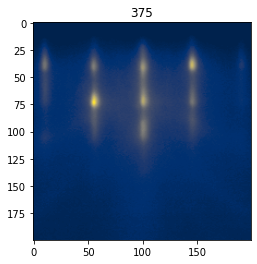

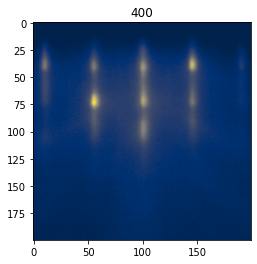

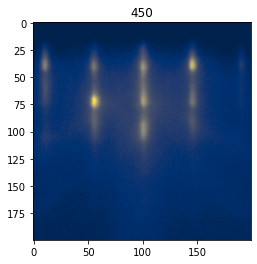

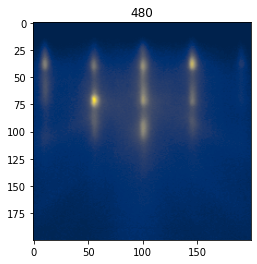

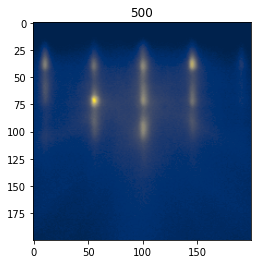

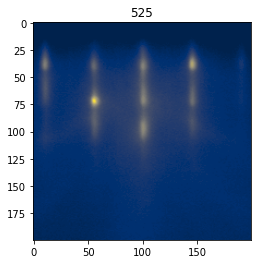

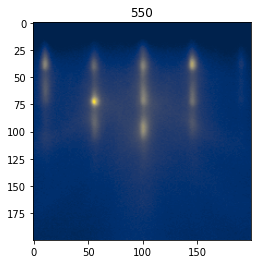

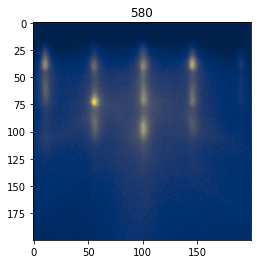

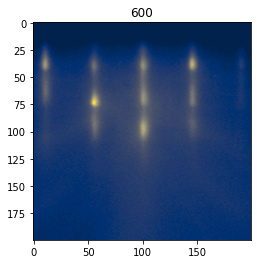

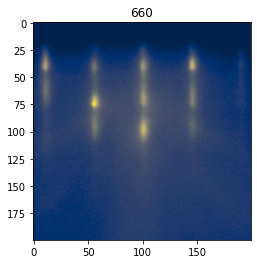

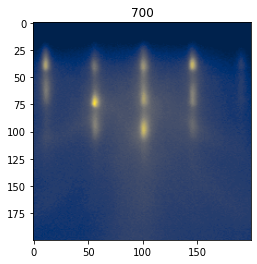

In [60]:
crop_rds = OrderedDict()
for name, rd in rds.items():
    masks = masker.predict(rd)
    rdm_streak = RheedMask(rd, masks['streak'])
    rdm_spot = RheedMask(rd, masks['spot'])

    # rdm_streak.get_regions(with_intensity=True)
    # rdm_streak.filter_regions(min_area=10)
    rdm_spot.get_regions(with_intensity=True)
    rdm_spot.filter_regions(min_area=10)

    db, r_i, _ = rdm_spot.get_direct_beam()

    db = (round(db[0]), round(db[1]))

    sx = db[0] + offset
    sy = db[1] - window_width//2
    ex = db[0] + offset + window_height
    ey = db[1] + window_width//2

    cr_rdm_spot = rdm_spot.crop(sx=sx, sy=sy, ex=ex, ey=ey, inplace=False)
    cr_rdm_streak = rdm_streak.crop(sx=sx, sy=sy, ex=ex, ey=ey, inplace=False)
    
    crop_rds[name] = cr_rdm_spot.rd

    # rdm_spot.plot_regions()
    fig, ax = cr_rdm_spot.rd.plot_pattern()
    ax.set_title(name)

In [61]:
crop_rdm_streaks = OrderedDict()
crop_rdm_spots = OrderedDict()

for name, rd in crop_rds.items():
    masks = masker.predict(rd)
    rdm_streak = RheedMask(rd, masks['streak'])
    rdm_spot = RheedMask(rd, masks['spot'])

    rdm_streak.get_regions(with_intensity=True)
    rdm_streak.filter_regions(min_area=10)
    rdm_spot.get_regions(with_intensity=True)
    rdm_spot.filter_regions(min_area=10)
    
    crop_rdm_streaks[name] = rdm_streak
    crop_rdm_spots[name] = rdm_spot


In [ ]:
rdm.plot_pattern_masks

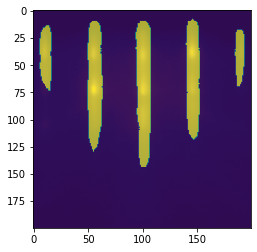

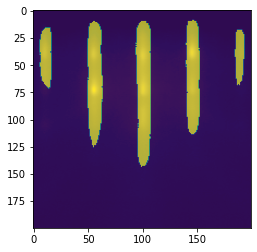

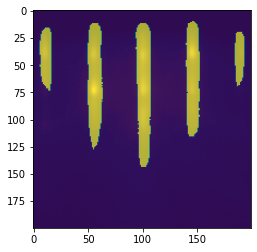

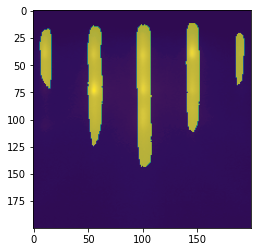

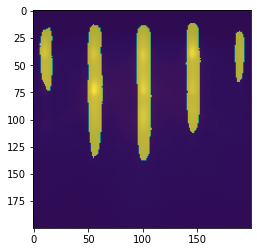

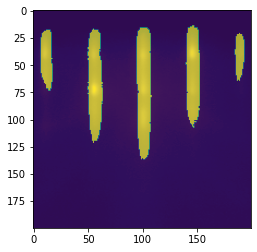

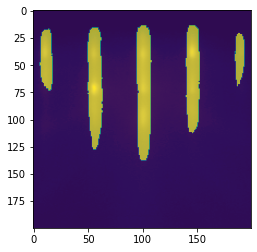

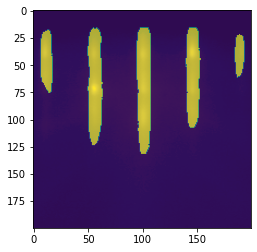

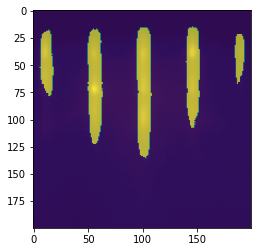

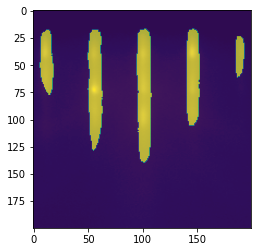

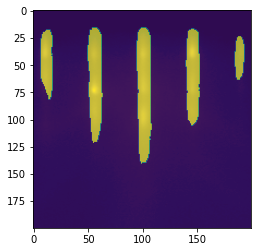

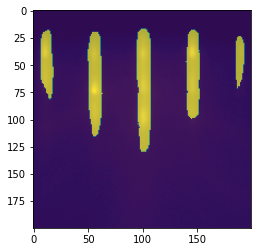

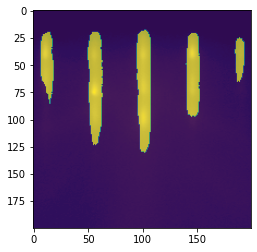

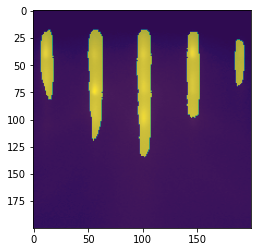

In [64]:
for name, rdm in crop_rdm_streaks.items():
    rdm.plot_pattern_masks()

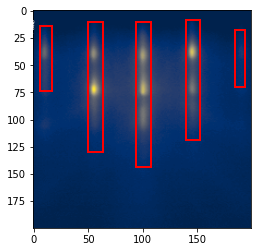

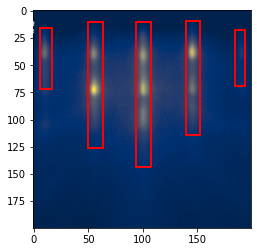

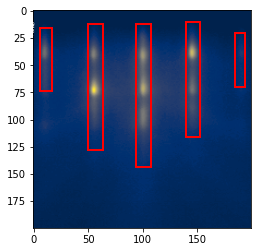

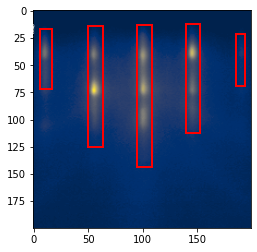

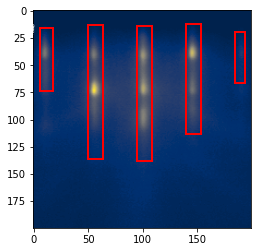

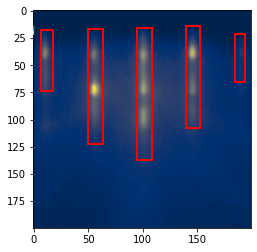

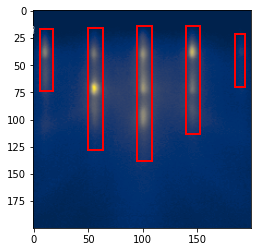

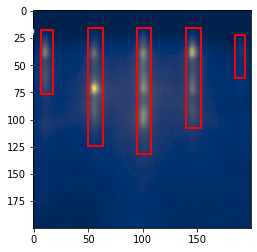

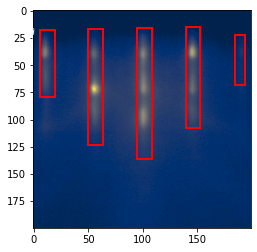

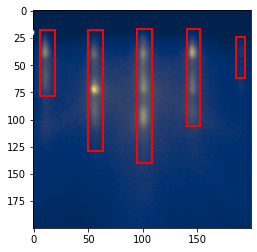

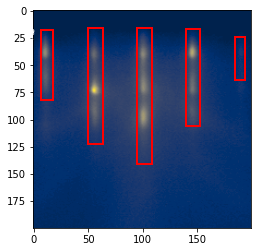

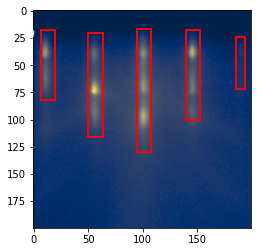

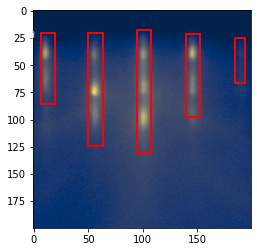

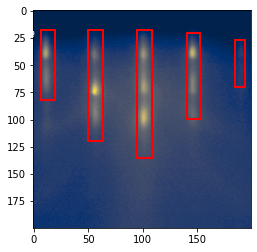

In [62]:
for name, rdm in crop_rdm_streaks.items():
    rdm.plot_regions()

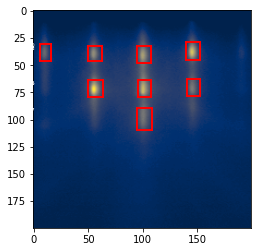

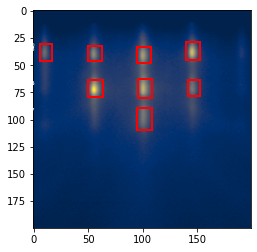

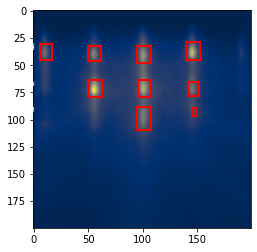

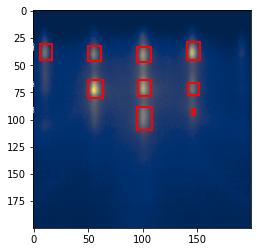

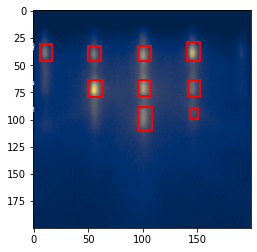

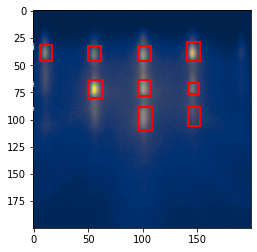

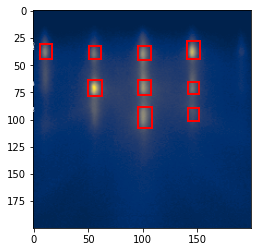

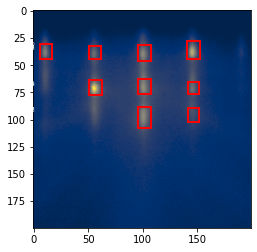

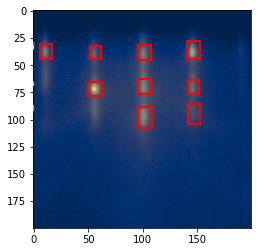

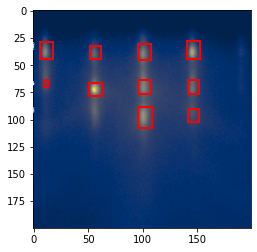

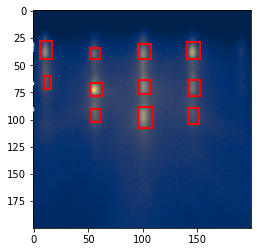

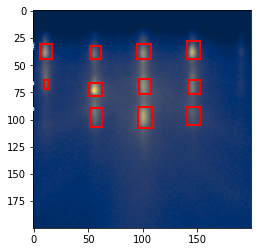

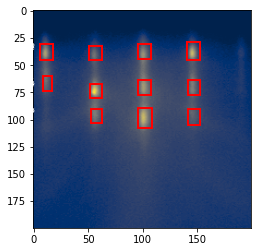

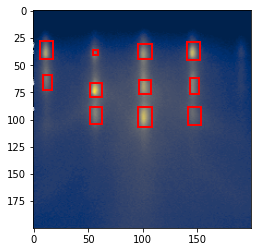

In [63]:
for name, rdm in crop_rdm_spots.items():
    rdm.plot_regions()

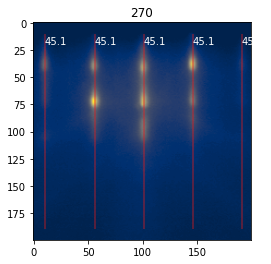

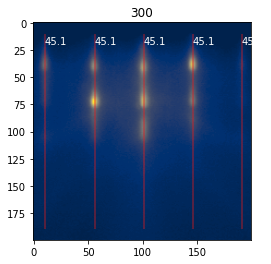

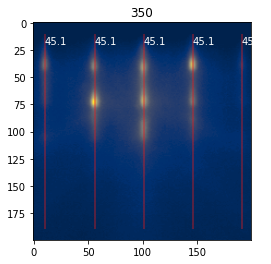

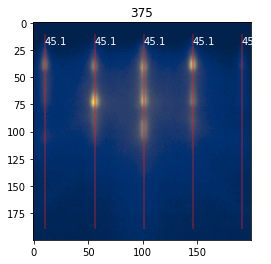

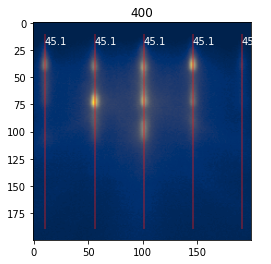

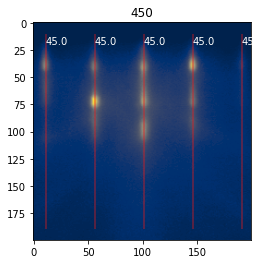

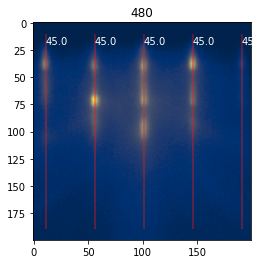

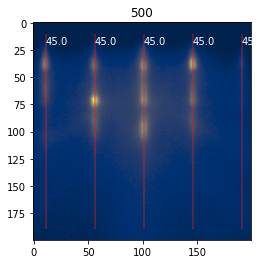

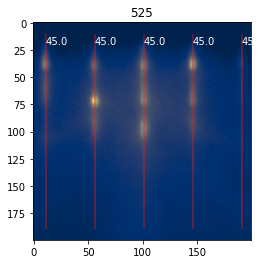

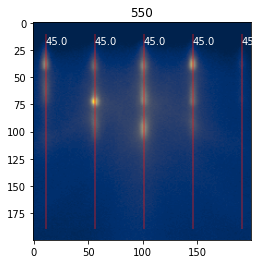

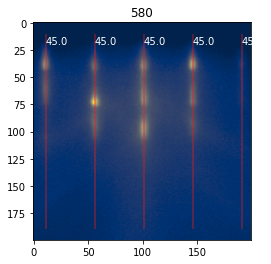

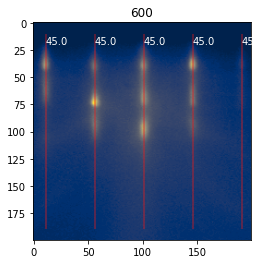

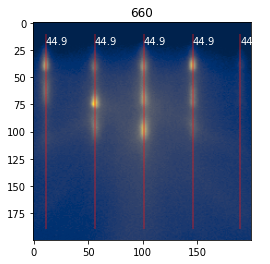

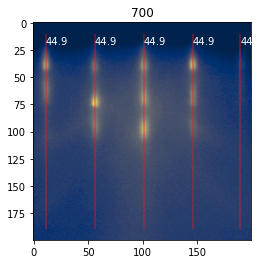

In [67]:
for name, rdm in crop_rdm_streaks.items():
    rdm.get_regions_collapse()
    rdm.clean_collapse(smooth=True, rm_bg=False, scale=True)
    rdm.fit_collapse_peaks(height=0.001, threshold=0.000, prominence=0.001)
    rdm.analyze_peaks_distance_cent(tolerant=0.2, abs_tolerant=15, allow_discontinue=1, )
    fig, ax = plt.subplots()
    rdm.plot_peak_dist(ax=ax)
    ax.set_title(name)
    

In [68]:
Ts = []
Ds = []
Ds_err = []
for name, rdm in crop_rdm_streaks.items():
    avg_dist = rdm.collapses_peaks_flatten_ana_res[0].avg_dist
    avg_err = rdm.collapses_peaks_flatten_ana_res[0].avg_err
    Ts.append(name)
    Ds.append(avg_dist)
    Ds_err.append(avg_err)    

Text(0, 0.5, 'Distance (pixel)')

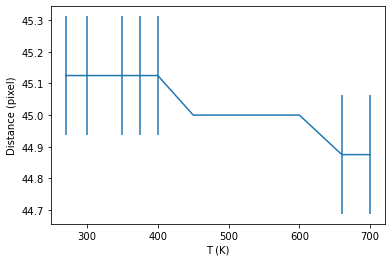

In [70]:
plt.errorbar(Ts, Ds, Ds_err)
plt.xlabel("T (K)")
plt.ylabel("Distance (pixel)")

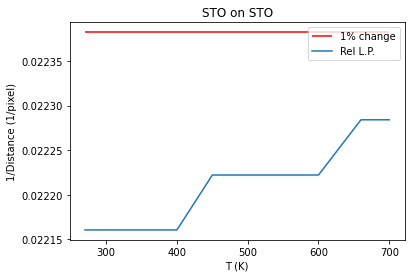

In [90]:
plt.title("STO on STO")

plt.errorbar(Ts, 1/np.array(Ds), label="Rel L.P.")
plt.xlabel("T (K)")
plt.ylabel("1/Distance (1/pixel)")

plt.hlines(y=1/np.array(Ds)[0] * 1.01, xmin=270, xmax=700, color="red", label="1% change")
plt.legend()

In [80]:
3.6e-5 * (700-270)

0.01548

In [87]:
3.9e-5 * (700-270)

0.01677

In [85]:
np.array(Ds)[0]

45.125

In [88]:
np.array(Ds)[0] * (1 / (1 + 0.0167))

44.38379069538704

In [91]:
[ for c, p in zip(rdm.collapses, rdm.collapses_peaks) ] 

[array([4]), array([6]), array([6]), array([5]), array([5])]

[array([11]), array([56]), array([101]), array([146]), array([190])]

In [100]:
rdm.collapses_peaks_ws[2] - rdm.collapses_peaks_ws[0]

array([90])

In [104]:
rdm.collapses_peaks_ws

[array([11]), array([56]), array([101]), array([146]), array([190])]

In [119]:
rdm.get_close_region??

In [120]:
[ rdm._get_region_centroid(region) for region in rdm.regions ]

[(49.9198230709765, 12.29032394549483),
 (70.239720844896, 57.03492673247086),
 (76.04586560076126, 101.6122878670324),
 (60.45671076942466, 146.3984117058418),
 (48.82162682283132, 189.26260175249763)]

In [123]:
rdm.get_close_region??

In [135]:
def get_close_region(self, x, y):
    centroids = np.stack([ self._get_region_centroid(region) for region in self.regions ], axis=0)
    dists = np.linalg.norm(centroids - np.array([x,y]), axis=1)
#     print(dists)
    i = np.argmin(dists)
    return self.regions[i], i

[141.14017805  94.14146701  49.38773343  16.21013433  46.93283138]
0


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

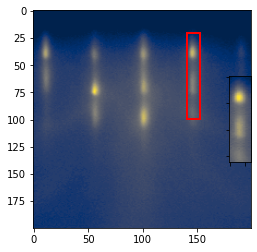

In [134]:
r, i = get_close_region(rdm, 76, 151)
print(0)
rdm.plot_region(i)

[136.50225585  49.03557589  93.2779159    6.33891093 179.66955115]
[47.51581464 45.65833813  4.8162658  95.31521645 93.87244071]
[136.46552631  49.03098814  93.45681863   6.56391082 179.57013557]
[47.57332294 45.6503456   3.94835121 95.34012107 93.84709807]
[136.48805722  49.45982359  93.62818029   5.69491605 179.45208303]
[47.07985861 45.44699261  3.33819895 95.00038968 93.4637483 ]
[136.54721158  94.3561567   49.77712918   6.07150999 179.50976172]
[47.37804136  0.90676956 45.20484327 95.02087514 93.47173419]
[136.69902718  50.71157554  93.93654339   5.0401363  179.51779   ]
[47.36236679 44.90916201  2.36710331 94.46468676 93.82783882]
[136.5688769   94.11216498  50.39956569   4.59037574 179.56361613]
[47.63596196  1.67682389 44.94061466 94.13962438 93.89553942]
[ 94.1070799  136.55257313  50.48485805   4.27896864 179.46080681]
[ 1.55203531 47.01563136 44.932159   94.10773903 93.41259654]
[ 50.79170718  93.98275443 136.51837522   3.55319694 179.48343056]
[44.8494018   2.38380683 47.24

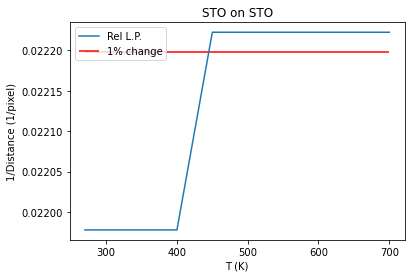

In [130]:
Ts = []
Ds = []
for name, rdm in crop_rdm_streaks.items():
    r, rid_l = get_close_region(rdm,x=50, y=10)
    r, rid_c = get_close_region(rdm,x=75, y=101)
    dist = (rdm.collapses_peaks_ws[rid_c] - rdm.collapses_peaks_ws[rid_l])/2
    Ts.append(name)
    Ds.append(dist)
    
plt.title("STO on STO")

plt.plot(Ts, 1/np.array(Ds), label="Rel L.P.")
plt.xlabel("T (K)")
plt.ylabel("1/Distance (1/pixel)")

plt.hlines(y=1/np.array(Ds)[0] * 1.01, xmin=270, xmax=700, color="red", label="1% change")
plt.legend()

1 0
1 0
1 0
2 0
1 0
2 0
2 1
0 2
2 0
3 1
0 2
3 2
2 3
1 3


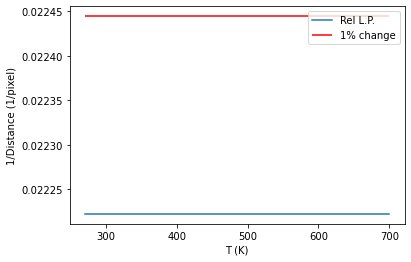

In [137]:
Ts = []
Ds = []
for name, rdm in crop_rdm_streaks.items():
    r, rid_l = get_close_region(rdm,x=75, y=50)
    r, rid_r = get_close_region(rdm,x=75, y=151)
    print(rid_l, rid_r)
    dist = (rdm.collapses_peaks_ws[rid_r] - rdm.collapses_peaks_ws[rid_l])/2
    Ts.append(name)
    Ds.append(dist)
    
# plt.title("STO on STO")

plt.plot(Ts, 1/np.array(Ds), label="Rel L.P.")
plt.xlabel("T (K)")
plt.ylabel("1/Distance (1/pixel)")

plt.hlines(y=1/np.array(Ds)[0] * 1.01, xmin=270, xmax=700, color="red", label="1% change")
plt.legend()

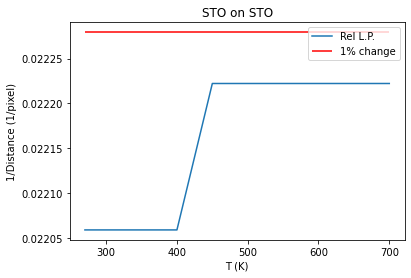

In [138]:
Ts = []
Ds = []
for name, rdm in crop_rdm_streaks.items():
    r, rid_l = get_close_region(rdm,x=50, y=10)
    r, rid_c = get_close_region(rdm,x=75, y=151)
    dist = (rdm.collapses_peaks_ws[rid_c] - rdm.collapses_peaks_ws[rid_l])/3
    Ts.append(name)
    Ds.append(dist)
    
plt.title("STO on STO")

plt.plot(Ts, 1/np.array(Ds), label="Rel L.P.")
plt.xlabel("T (K)")
plt.ylabel("1/Distance (1/pixel)")

plt.hlines(y=1/np.array(Ds)[0] * 1.01, xmin=270, xmax=700, color="red", label="1% change")
plt.legend()